In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from scipy import ndimage


import time

from settings import DATA_201701, CUTOFF_DATE, INFO_FLAG, COURSE_CODES, NOT_COURSE_CODES, 



In [36]:
# configure here
# COURSE_CODES = ["CSC2", "MAT237", "STA257", "STA261"]
# NOT_COURSE_CODES = ["HAS_TO_BE_HERE_STRING"]
# PNG_SAVED = "./graphs/fig.png"
    

In [45]:
df = pd.read_table(DATA_201701, sep='\t')

# preliminary filtering

COURSE_PATTERN = r"^({})".format("|".join(COURSE_CODES))
NOT_COURSE_PATTERN = r"^({})".format("|".join(NOT_COURSE_CODES))

df = df.loc[
    (df["waitlist"] == "Y") &
    (df["enrollmentCapacity"]) < 9999 &
    (df["section"] == "S") & 
    (df["teachingMethod"] == "LEC") & 
    (df["courseCode"].str.contains(COURSE_PATTERN)) & 
    (~df["courseCode"].str.contains(NOT_COURSE_PATTERN))
   ]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  del sys.path[0]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [46]:
# Filter by date 
CUTOFF_DATE_EPOCH = int(time.mktime(time.strptime(CUTOFF_DATE, '%Y-%m-%d')))

start_epoch = df["epochTime"].min()
SECONDS_PER_DAY = 86400

df = df.loc[
    (df["epochTime"] <= CUTOFF_DATE_EPOCH)
]    

# Adding relevant columns
df["id"] = df.apply(lambda row: row.courseCode + "_" + str(row.sectionNumber), axis=1)
df["time"] = df.epochTime.apply(lambda cur_epoch: 
                                (int(cur_epoch) - int(start_epoch)) / SECONDS_PER_DAY)

df["waitlistPer"] = df.apply(lambda row: row.actualWaitlist / row.enrollmentCapacity, axis=1)
df["enrollmentPer"] = df.apply(lambda row: row.actualEnrolment / row.enrollmentCapacity, axis=1)

In [47]:
# Filter by waitlist demands 

WAITLIST_DEMAND_THRESHOLD = 0.05 
filtered = df.groupby(["id"])["waitlistPer"].mean()
filtered = filtered[filtered >= WAITLIST_DEMAND_THRESHOLD].to_dict()

def filterByWaitlist(row):
    if row.id in filtered:
        return filtered[row.id]
    else:
        return -1

df["waitlist_mean"] = df.apply(filterByWaitlist, axis=1)
df = df.loc[
    (df["waitlist_mean"] != -1)
]


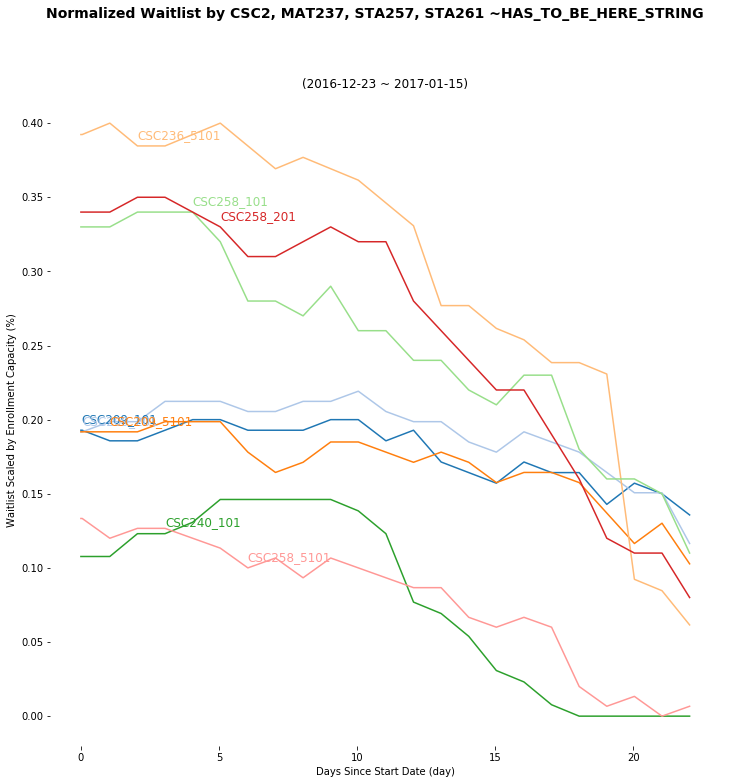

In [48]:

%matplotlib inline

# [tutorial](http://spartanideas.msu.edu/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/)

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)   

# plot resize
fig = plt.figure(figsize=(12, 12))
fig.suptitle(
    "Normalized Waitlist by {} {}".format(
        ", ".join(COURSE_CODES),
        ", ".join("~" + c for c in NOT_COURSE_CODES)
    ), 
    fontsize=14, 
    fontweight='bold'
)


# Set axis labels
ax = plt.subplot(111)    
ax.set_title("(2016-12-23 ~ {})".format(CUTOFF_DATE))
ax.set_ylabel("Waitlist Scaled by Enrollment Capacity (%)")
ax.set_xlabel("Days Since Start Date (day)")

# Remove the plot frame lines.  
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 

# axis ticks 
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()


courseID = df["id"].unique()

for rank, course_id in enumerate(courseID):
    color = tableau20[rank % 20]
    
    dfByCourse = df.loc[
        (df.id == course_id)
    ]
    
    num_sample_pts = dfByCourse["id"].size
    
    plt.plot(
        list(dfByCourse["time"].values), 
        list(dfByCourse["enrollmentPer" if INFO_FLAG else "waitlistPer"].values),
        color=color,
        label=course_id
    )
    plt.text(
        list(dfByCourse["time"].values)[rank % num_sample_pts],
        list(dfByCourse["enrollmentPer" if INFO_FLAG else "waitlistPer"].values)[rank % num_sample_pts] + 0.005,
        course_id,
        fontsize=12,
        color=color
            )
plt.savefig(PNG_SAVED, dpi=200)
